In [ ]:

import collections
from collections import defaultdict
from IPython import display
import math
from matplotlib import pyplot as plt
import os
import pandas as pd
import random
import re
import shutil
import sys
import tarfile
import requests
import zipfile
import hashlib
d2l = sys.modules[__name__]


In [ ]:
%matplotlib inline
import my_utils as mu
import time
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data


#Device/Other Utilities


##Device GPU *Check*


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Mac Only
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# print(device)

cuda


In [ ]:
def try_gpu(i=0):  #for use in Colab
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

##Timer

In [ ]:
class Timer:  #save
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

##Animator


In [ ]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

#DataLoader


In [ ]:
#with data augumenation
def load_data_cifar10(batch_size, resize=None):  #save
    """Download the CIFAR10 dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))

    trans_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trans_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    cifar10_train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=trans_train, download=True)
    cifar10_test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform=trans_test, download=True)

    return (data.DataLoader(cifar10_train, batch_size, shuffle=True,
                            num_workers=2, pin_memory=True)),(data.DataLoader(cifar10_test, batch_size, shuffle=False,
                            num_workers=2, pin_memory=True))


In [ ]:
batch_size = 256
train_iter, test_iter = load_data_cifar10(batch_size)


100%|██████████| 170498071/170498071 [00:13<00:00, 13107593.93it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [ ]:
X, y = next(iter(train_iter)) # first batch
print(X.size())

print(X[0])

print(y.size())

torch.Size([256, 3, 32, 32])
tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [ 0.1529, -0.3098, -0.9216,  ..., -0.8039, -1.0000, -1.0000],
         [ 0.1608, -0.3569, -0.7412,  ..., -0.7255, -1.0000, -1.0000],
         [ 0.2706,  0.1216,  0.0275,  ...,  0.0745, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [ 0.0667, -0.3412, -0.9216,  ..., -0.9373, -1.0000, -1.0000],
         [ 0.0353, -0.3961, -0.7569,  ..., -0.7490, -1.0000, -1.0000],
         [ 0.1294,  0.0353, -0.0510,  ...,  0.0039, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.000

#Block



In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, k, kernel_size=3, stride=1, padding=1):
        super(Block, self).__init__()

        self.k = k

        # Linear/MLP layer
        self.linear1 = nn.Linear(in_channels, 20)
        self.linear2 = nn.Linear(20, k)


        # Spatial average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        # Non-linear activation function
        self.activation = nn.ReLU()


        #### Max pooling layer convolutional layer
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        #### Batchnorm layer convolutional layer
        self.batchnorm = nn.BatchNorm2d(out_channels)


        # Convolutional layers
        conv_layers_list = []

        for i in range(k):
            conv_layers_list.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding))


        self.conv_layers = nn.ModuleList(conv_layers_list)


    def forward(self, x):
        # Spatial average pooling layer
        a = self.avgpool(x)
        # print(a.size())

        # Flatten spatial average tensor
        a = torch.flatten(a, start_dim=1)
        # print(a.size())

        # Linear/MLP layer
        a = self.linear1(a)
        a = self.linear2(a)
        # print(a.size())

        # Non-linear activation function
        a = self.activation(a)
        # print(a.size())

        # Convolutional layers

        output = None

        for k in range(self.k):
            conv_k = self.conv_layers[k]

            x_k = conv_k(x) # [256, 64, 32, 32], a = [256], ak = [256, 1, 1, 1]

            ak = a[:, k].unsqueeze(1).unsqueeze(2).unsqueeze(3)
            # print(ak.shape)
            prod_a_conv = ak * x_k

            if output is None:
                output = prod_a_conv
            else:
                output = output + prod_a_conv #output = [256, 64, 32, 32]

        #### Batchnorm layer convolutional layer
        output = self.batchnorm(output)
        output = self.activation(output)

        #### Max pooling layer convolutional
        output = self.max_pool(output)

        return output

#Model

In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_classes, k):
        super(MyModel, self).__init__()

        # Define the blocks
        self.block1 = Block(in_channels=3, out_channels=64, k=k, kernel_size=3, stride=1, padding=1)
        self.block2 = Block(in_channels=64, out_channels=128, k=k, kernel_size=3, stride=1, padding=1)
        self.block3 = Block(in_channels=128, out_channels=256, k=k)
        self.block4 = Block(in_channels=256, out_channels=512, k=k)

        # Define the classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes) #Crossentropyloss will apply logsoftmax when loss is called

    def forward(self, x):
        # Pass input through blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        # Get output f
        f = self.avgpool(x)
        f = torch.flatten(f, start_dim=1)

        # Pass output f through classifier
        y = self.fc(f)

        return y

#Loss & Optimiser


In [ ]:
#these are defined within the training script

# loss = nn.CrossEntropyLoss()

# lr = 0.001
# optimizer = torch.optim.Adam(net.parameters(), lr)



#Evaluation


In [ ]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

In [ ]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #save
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    metric = Accumulator(2)  # num_corrected_examples, num_examples
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

#Training Script


In [ ]:
# Defined in file: ./chapter_convolutional-neural-networks/lenet.md
def train_ch6(net, train_iter, test_iter, num_epochs, lr,
              device=try_gpu()):
    """Train and evaluate a model with CPU or GPU."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()

    animator = Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = Timer()

    for epoch in range(num_epochs):
        metric = Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))


    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

#Blocks = 4, Out_channels = 512, MLP Parameters: 3-20-K, Stride = 1, 50 Epoch, K = 16, Lr = 0.001


loss 0.086, train acc 0.970, test acc 0.869
757.5 examples/sec on cuda


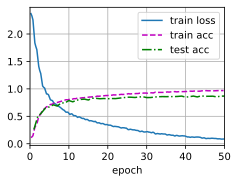

In [ ]:
net = MyModel(num_classes=10, k=16)
num_epochs = 50
lr = 0.001
train_ch6(net, train_iter, test_iter, num_epochs, lr, device)
